### Download data

We will download data from NYU box and extract it to local disk. It may take a couple of minutes

In [3]:
! wget -O weather.zip "https://nyu.box.com/shared/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip"

--2021-01-28 14:17:12--  https://nyu.box.com/shared/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip
Resolving nyu.box.com (nyu.box.com)... 107.152.29.197
Connecting to nyu.box.com (nyu.box.com)|107.152.29.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip [following]
--2021-01-28 14:17:12--  https://nyu.box.com/public/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip [following]
--2021-01-28 14:17:12--  https://nyu.app.box.com/public/static/7m3377viu18qg8ymos0n2sjsqxl1ikex.zip
Resolving nyu.app.box.com (nyu.app.box.com)... 107.152.29.201
Connecting to nyu.app.box.com (nyu.app.box.com)|107.152.29.201|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/b

In [ ]:
! unzip weather.zip

In [17]:
data_path = "/Users/sreyas/Dropbox/Spring 2021/data/weather/"

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from os import listdir
from numpy import linalg as LA

In [4]:
np.random.seed(2019)

In [5]:
# data loading helper functions 

def extract_temp(file_name,col_ind):
    data_aux = np.loadtxt(file_name, usecols=range(10))
    data = data_aux[:,col_ind]
    err_count = 0
    ind_errs = []
    for ind in range(data.shape[0]):
        if data[ind] > 100 or data[ind] < -100:
            err_count = err_count + 1
            ind_errs.append(ind)
            data[ind] = data[ind-1]  
    print( "File name: " + file_name)
    print( "Errors: " + str(err_count) + " Indices: " + str(ind_errs))
    return data

def create_data_matrix(str_path):
    file_name_list = listdir(str_path)
    file_name_list.sort()
    col_ind = 8 # 8 = last 5 minutes, 9 = average over the whole hour
    data_matrix = []
    ind = 0
    for file_name in file_name_list:
        if file_name[0] == '.':
            continue
        else:
            print("Station " + str(ind))
            ind = ind + 1
            data_aux = extract_temp(str_path + file_name,col_ind)
            if len(data_matrix) == 0:
                data_matrix = data_aux
            else:
                data_matrix = np.vstack((data_matrix,data_aux))
    return data_matrix.T

def running_mean(x):
    l = 24
    return np.convolve(x, np.ones(l)/l, mode='valid')

def process_name(x):
    x = x[14:]
    x = x[:-7]
    x = x.translate(str.maketrans('','','_1234567890'))
    return x[2:] + ", " + x[:2]

In [19]:
load_files = False #either read through all csvs files or just load the precomputed npy file

if load_files:
    str_path_2015 = data_path + "hourly/2015/"
    data_matrix = create_data_matrix(str_path_2015)
    str_path_2016 = data_path + "hourly/2016/"
    data_matrix_2016 = create_data_matrix(str_path_2016)
else:
    data_matrix = np.load(data_path +"hourly_temperature_2015.npy")
    data_matrix_2016 = np.load(data_path +"hourly_temperature_2016.npy")

In [20]:
file_name_list = listdir(data_path + "hourly/2015/")
file_name_list.sort()

In [21]:
print(data_matrix.shape)

(8760, 134)


compute centered data matrix, covariance matrix and correlation matrix

In [22]:
mean = np.mean(data_matrix,axis=0)
data_matrix_centered = data_matrix - mean
cov_matrix = np.cov(data_matrix.T)
# cov_matrix_sanity_check = data_matrix_centered.T @ data_matrix_centered / data_matrix_centered.shape[0]
corr_matrix = np.corrcoef(data_matrix.T)

In [23]:
print(cov_matrix.shape)

(134, 134)


Let's compute the principal directions and the variance along each direction by performing an eigendecomposition of the covariance matrix

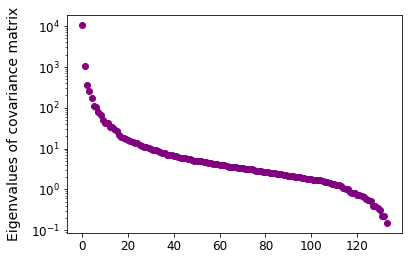

In [29]:
pc_vars, pds = LA.eig(cov_matrix)

plt.figure()
plt.semilogy(np.sort(pc_vars)[::-1],linestyle="None",marker='o',color='purple')
plt.ylabel('Eigenvalues of covariance matrix',fontsize=14,labelpad=10)
plt.tick_params(labelsize=12)

Note that the plot is in logscale. The eigenvalues fall off very sharply. 

### Let's visualize the top 3 principal directions

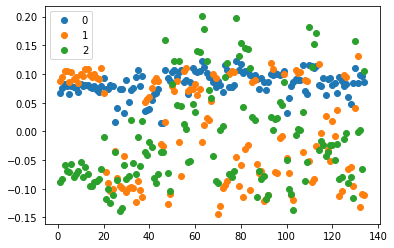

In [26]:
r = 3

plt.figure()
for ind in range(r): 
    plt.plot(np.arange(1,data_matrix_centered.shape[1]+1),pds[:,ind],'o',label=str(ind))
plt.legend()


### Principal Components

Principal components are the projection of the data onto the principal directions. Here, we are going to visualize the coefficient of these projections. 

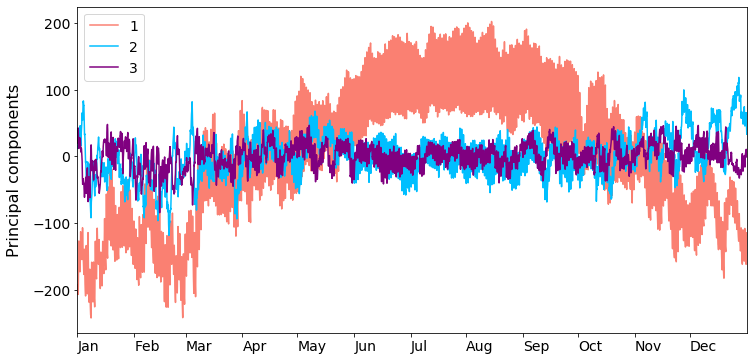

In [30]:

pcs = np.zeros((data_matrix_centered.shape[0],r))
for ind in range(r):
    pcs[:,ind] = data_matrix_centered @ pds[:,ind]
    
plt.figure(figsize=(12,6))
colors = ['salmon','deepskyblue','purple']
for ind in range(r): 
    plt.plot(pcs[:,ind],label=str(ind+1),color=colors[ind])
plt.legend(fontsize=14)
plt.ylabel('Principal components',fontsize=16,labelpad=10)
xtick_labels = ['Jan', 'Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
xtick_vals = 24*np.cumsum(np.array([0,31,28,31,30,31,31,30,31,30,31,30]))
plt.xticks(xtick_vals, xtick_labels)
plt.tick_params(labelsize=14)
plt.xlim([0,data_matrix_centered.shape[0]])
ax = plt.gca()
for tick in ax.xaxis.get_majorticklabels():
    tick.set_horizontalalignment("left")